**Project 2 : Melanoma detection with convoluted neural networks (CNNs)**

What is melanoma? 

Melanoma is, simply put, skin cancer. Some people refer to melanoma as maligant melanoma, but it is accepted in the medical
community that there is no such thing as "benign melanoma". It is either melanoma (the benign case) or non-melanoma
(the malignant case). 

**About this project**

In this project, I aim to build a visual diagnostic tool that uses deep learning to detect melanoma from image data. It is important to note that while a visual examination is one of the first steps in diagnosing malignant cases, it is usually followed up by more thorough investigations such as a biopsy. Therefore, tools such as these are not a replacement for clinical diagnosis, but can rather serve as an assistive tool.

The core model is a convoluted neural network (CNN), a deep learning algorithm known to work well for image classification tasks. The image dataset used for training and testing the current tool is publicy available on kaggle under the name ["Melanoma Cancer Image dataset"](https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset/data). 

**More on the dataset**

The dataset consists of a total of 13,879 images labeled benign or malignant (skin lesions, moles, etc.). It comes in two directories:

1. Train: 6289 benign cases + 5590 malignant cases
2. Test: 1000 benign cases + 1000 malignant cases

The number of benign and malignant cases are well balanced in both subsets, so significant class imbalance issues are not expected. The dataset does not include a separate validation set, so it makes sense to derive a validation dataset (or dev dataset as I refer to it) from the train dataset. I extracted 20% of the train dataset as the validation set (code included in this notebook). 

**Package requirements**

numpy, pandas, matplotlib, scikit-learn, tensorflow, random, pickle, os

In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, Accuracy, AUC
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
import random
import pickle

In [4]:
#path to the train and test datasets
main = '/kaggle/input/melanoma-cancer-dataset/'
train_dir = os.path.join(main, "train")
test_dir = os.path.join(main, "test")

In [5]:
image_size = (224, 224) #resize each image to 224 x 224 pixels
batch_size = 32 #load 32 images at a time (in batches)

#since there are only train and test datasets here, I will split the train dataset further into
#train and validation datasets (20% of the train set)

#if there is only one big dataset which is not divided at all, it is worth dividing the dataset manually
#to train, test, and dev.

#applying image augmentations on train_dataset so that teh model is trained on slight variations of the data
#since this is a biological dataset, augmentations like horizontal_flip and shear are not realistic.
#it pays to talk to experts in the respective domain to figure out which transformations make sense

train_datagen = ImageDataGenerator(
    rescale = 1./255,    # normalises pixel values from [0,255] to [0,1]
    rotation_range = 15, # randomly rotate images up to 15 degrees
    width_shift_range = 0.2,#random horizontal translation (20% of the image width), part of the image that was pushed out is
                             #replaced with constant black padding when default
    height_shift_range = 0.2, #random vertical translation (20% of the image height), ''
    zoom_range = 0.2, #random zooming in and out
    validation_split = 0.2 #subset 20% of the train set as validation/dev set
)

#no variations applied to test and dev datasets, it used to evaluate the performance of the trained model on unmodified images
dev_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

#train dataset
train = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "binary",
    subset = "training"
)

#dev dataset
dev = dev_datagen.flow_from_directory(
    directory = train_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "binary",
    subset = "validation"
    
)

#test dataset
test = test_datagen.flow_from_directory(
    directory = test_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "binary"

)

Found 9504 images belonging to 2 classes.
Found 2375 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
#check the class mapping
train.class_indices, dev.class_indices, test.class_indices

({'Benign': 0, 'Malignant': 1},
 {'Benign': 0, 'Malignant': 1},
 {'Benign': 0, 'Malignant': 1})

In [7]:
#validation_split within ImageDataGenerator() does not ensure stratified split of the train dataset
#into dev and train sets. Checking if the benign and malignant distributions in the two datasets
#are comparable and not skewed

np.bincount(train.classes), np.bincount(dev.classes), np.bincount(test.classes)
#not bad

(array([5032, 4472]), array([1257, 1118]), array([1000, 1000]))

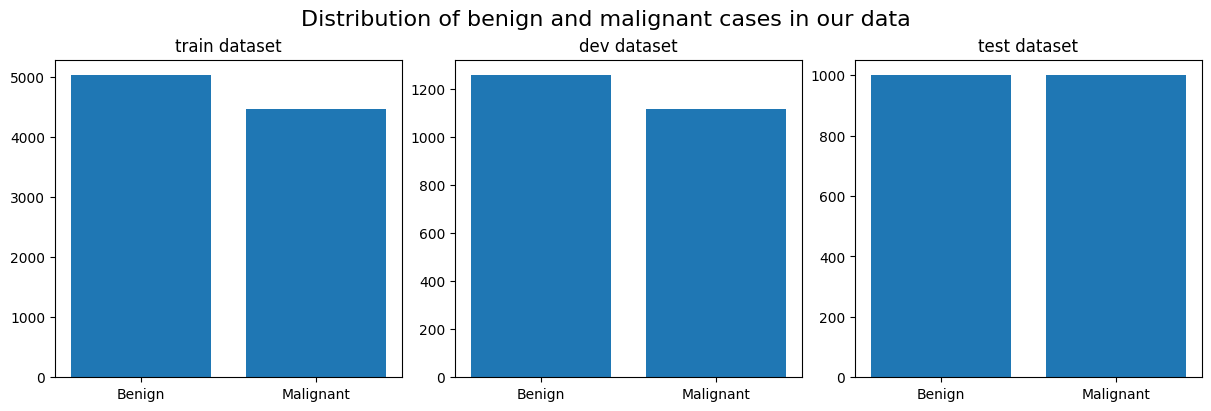

In [8]:
#visualize as bar plots if you like
datasets = [train, dev, test]
strings = ["train dataset", "dev dataset", "test dataset"]
fig, ax = plt.subplots(1,3, figsize = (12, 4), constrained_layout = True)
plt.suptitle("Distribution of benign and malignant cases in our data", size = 16)
for i in range(len(strings)):
  class_labels = datasets[i].class_indices
  class_names = {v: k for k, v in class_labels.items()}
  class_counts = np.bincount(datasets[i].classes, minlength = len(class_names))
  ax[i].bar(class_names.values(), class_counts)
  ax[i].set_title(strings[i])

In [8]:
#take a look at some of the images at random
#define a function, plot_random, for ease of plotting from train, test, or dev datasets

def plot_random(dataset):
  fig, ax = plt.subplots(4,4, figsize = (10,8))
  fig.tight_layout(pad=0.20,rect=[0,.05, 1, 0.91])

  dataset.batch_index = random.randint(0, len(train)-1) #len(train) = no. of batches in the train directory
  images, labels = next(dataset)

  for i, axes in enumerate(ax.flat):
    if i < len(images):
      axes.imshow(images[i])
      axes.set_axis_off()
      axes.set_title("malignant" if labels[i] == 1 else "benign")

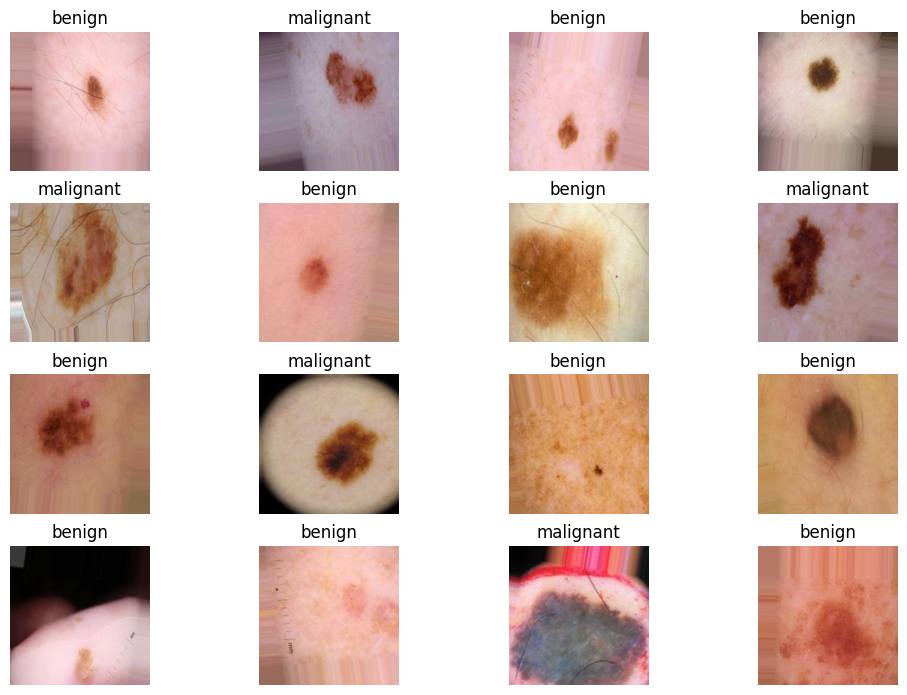

In [9]:
#plotting random images from the train dataset (remember, the augmentations have been applied to images in the train dataset)
plot_random(train)

In [8]:
#defining three CNN models with variations in the number of conv and dense layers
#this could help with choosing or deciding on the architecture of the neural network


model1 = Sequential([
    # First convolutional block
    Conv2D(32, (3,3), activation = "relu", padding= "same", kernel_regularizer = regularizers.l2(0.001), input_shape = (224, 224, 3)), #32 filters, kernel size = (3,3)
    #padding = "same"is added to the conv layer to maintain spatial dimensions adn avoid shrinking before flattening (essentially reduces information loss)
    BatchNormalization(),  #can help stabilize and speed up traning
    MaxPooling2D(pool_size = (2,2)), #dimension reduction

    #Second convolutional block
    Conv2D(64, (3,3), activation = "relu", padding= "same", kernel_regularizer = regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    #flatten feature map
    Flatten(),

    #Dense layer
    Dense(units = 1, activation = "sigmoid"),  
], name = "model1")



model2 = Sequential([
    #First convolutional block
    Conv2D(32, (3,3), activation = "relu",padding= "same",kernel_regularizer = regularizers.l2(0.001), input_shape = (224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    #second convolutional block
    Conv2D(64, (3,3), activation = "relu", padding= "same", kernel_regularizer = regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    #third convolutional block
    Conv2D(128, (3,3), activation = "relu", padding= "same", kernel_regularizer = regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    #flatten
    Flatten(),

    #first dense layer
    Dense(units = 128, activation = "relu", kernel_regularizer = regularizers.l2(0.001)),
    Dropout(0.5),

    #secind dense layer
    Dense(units = 1, activation = "sigmoid"),
], name = "model2")


model3 = Sequential([
    #first convolutional layer
    Conv2D(32, (3,3), activation = "relu",padding= "same", kernel_regularizer = regularizers.l2(0.001), input_shape = (224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    #second convolutional layer
    Conv2D(64, (3,3), activation = "relu", padding= "same", kernel_regularizer = regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    #third convolutional layer
    Conv2D(128, (3,3), activation ="relu", padding= "same", kernel_regularizer = regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    #fourth convolutional layer
    Conv2D(256, (3,3), activation = "relu", padding= "same", kernel_regularizer = regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    #flatten
    Flatten(),

    #first dense layer
    Dense(units = 128, activation = "relu", kernel_regularizer = regularizers.l2(0.001)),
    Dropout(0.5),

    #last Dense layer
    Dense(units = 1, activation = "sigmoid"),

], name = "model3")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746728182.424129      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [21]:
#training, predicting with, and calculating performance metrics for all three models

model_list = [model1, model2, model3]
train_acc = [] #to hold accuracy of models when predicting on the train dataset
dev_acc = [] #to hold accuracy of models when predicting on the dev dataset
train_losses = []
dev_losses = []
precisions = []
recalls = []
histories = []
model_results = []

for model in model_list:
  #compile model
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ["accuracy", Precision(name = "precision"), Recall(name = "recall")])

  #print model summary
  print(f"summary of {model.name}\n")
  model.summary()

  # Set up early stopping and checkpointing
  #stop when recall on validation/dec set doesn't improve for ten epochs and roll back to the best model (not the last one)
  # recall is the most important performance metric for medical diagnostic tools. You don;t want your model
  # to continue training after it can no longer imporve recall because it won;t translate to any generalizable advantage to the model
  early_stop = EarlyStopping(monitor = "val_recall", patience = 10, restore_best_weights = True, mode = "max")
 
  checkpoint = ModelCheckpoint(f"/kaggle/working/best_{model.name}.keras", monitor = "val_recall", save_best_only = True)

  #train the model
  print(f"Training {model.name}....")
  history = model.fit(
      train,
      validation_data = dev,
      epochs = 50,
      callbacks = [early_stop, checkpoint]
  )
  print("....Done!\n")

  #append all model performance metrics to lists. Note I am appending the model from the last epoch, not the best epoch here
  print(f"Storing performance metrics for {model.name}...\n")
  train_acc.append(history.history["accuracy"][-1])
  dev_acc.append(history.history["val_accuracy"][-1])
  train_losses.append(history.history["loss"][-1])
  dev_losses.append(history.history["val_loss"][-1])
  precisions.append({
      "train": history.history["precision"][-1],
      "dev": history.history["val_precision"][-1]
  })
  recalls.append({
      "train": history.history["recall"][-1],
      "dev": history.history["val_recall"][-1]
  })
  histories.append(history)

#save histories and results

with open('/kaggle/working/model_histories.pkl', 'wb') as f:
    pickle.dump(histories, f)

import IPython
import time
#beep when code finishes running
IPython.display.Audio(data=None, autoplay=True, url="https://www.soundjay.com/button/beep-07.wav")

summary of model1



Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │         200,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,481 (861.25 KB)

 Trainable params: 220,289 (860.50 KB)

 Non-trainable params: 192 (768.00 B)

Training model1....
Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 127s 402ms/step - accuracy: 0.7849 - loss: 0.7657 - precision: 0.7747 - recall: 0.7708 - val_accuracy: 0.7760 - val_loss: 0.5247 - val_precision: 0.7526 - val_recall: 0.7809
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 108s 355ms/step - accuracy: 0.8185 - loss: 0.5812 - precision: 0.8163 - recall: 0.8023 - val_accuracy: 0.7844 - val_loss: 0.5927 - val_precision: 0.7644 - val_recall: 0.7835
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 107s 351ms/step - accuracy: 0.8404 - loss: 0.5496 - precision: 0.8334 - recall: 0.8281 - val_accuracy: 0.8021 - val_loss: 0.6994 - val_precision: 0.7852 - val_recall: 0.7979
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 108s 355ms/step - accuracy: 0.8444 - loss: 0.5055 - precision: 0.8400 - recall: 0.8274 - val_accuracy: 0.7322 - val_loss: 0.9123 - val_precision: 0.7726 - val_recall: 0.6109
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 107s 350ms/step - accuracy: 0.8525 - loss: 0.4800 - precision: 0.8523 - recall: 0.83

Model: "model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,457 (49.36 MB)

 Trainable params: 12,939,009 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)

Training model2....
Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 116s 361ms/step - accuracy: 0.7824 - loss: 1.2029 - precision: 0.7675 - recall: 0.7686 - val_accuracy: 0.6101 - val_loss: 2.9450 - val_precision: 0.8380 - val_recall: 0.2129
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 107s 353ms/step - accuracy: 0.8486 - loss: 0.7187 - precision: 0.8375 - recall: 0.8335 - val_accuracy: 0.7789 - val_loss: 0.9013 - val_precision: 0.7258 - val_recall: 0.8524
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 110s 360ms/step - accuracy: 0.8554 - loss: 0.6931 - precision: 0.8464 - recall: 0.8465 - val_accuracy: 0.8168 - val_loss: 0.8090 - val_precision: 0.7947 - val_recall: 0.8238
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 110s 360ms/step - accuracy: 0.8565 - loss: 0.6624 - precision: 0.8508 - recall: 0.8380 - val_accuracy: 0.8008 - val_loss: 0.7617 - val_precision: 0.7749 - val_recall: 0.8131
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 108s 354ms/step - accuracy: 0.8716 - loss: 0.5958 - precision: 0.8677 - recall: 0.85

Model: "model3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,813,121 (25.99 MB)

 Trainable params: 6,812,161 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

Training model3....
Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 117s 357ms/step - accuracy: 0.8010 - loss: 1.1254 - precision: 0.7846 - recall: 0.8045 - val_accuracy: 0.5305 - val_loss: 5.1338 - val_precision: 1.0000 - val_recall: 0.0027
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 107s 351ms/step - accuracy: 0.8577 - loss: 0.8636 - precision: 0.8387 - recall: 0.8582 - val_accuracy: 0.7651 - val_loss: 1.0758 - val_precision: 0.8390 - val_recall: 0.6199
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 107s 353ms/step - accuracy: 0.8657 - loss: 0.8227 - precision: 0.8524 - recall: 0.8645 - val_accuracy: 0.7899 - val_loss: 0.8986 - val_precision: 0.8397 - val_recall: 0.6843
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 107s 351ms/step - accuracy: 0.8658 - loss: 0.7967 - precision: 0.8482 - recall: 0.8674 - val_accuracy: 0.7937 - val_loss: 0.8833 - val_precision: 0.8198 - val_recall: 0.7200
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 107s 353ms/step - accuracy: 0.8725 - loss: 0.7477 - precision: 0.8630 - recall: 0.86

In [15]:
#looking at the training histories of all three models and checking if there is an overfit or an underfit
#writing a fuction to plot the different histories (loss, accuracy, precision, and recall)
def plot_history(metric):
  fig, ax = plt.subplots(1,3, figsize = (12,4), tight_layout= True)
  a = "val_"
  fig.suptitle(metric + " history for all three models", size = 16)
  for i in range(len(histories)):
    ax[i].plot(histories[i].history[metric], c = "blue", label = "train")
    ax[i].plot(histories[i].history[a+metric], c = "red", label = "dev")
    ax[i].set_title(model_list[i].name, size = 14)
    ax[i].set_xlabel("epochs", size = 12)
    ax[i].set_ylabel(metric, size = 12)
    ax[i].legend(loc = "upper right")
    ax[i].grid(True)
    

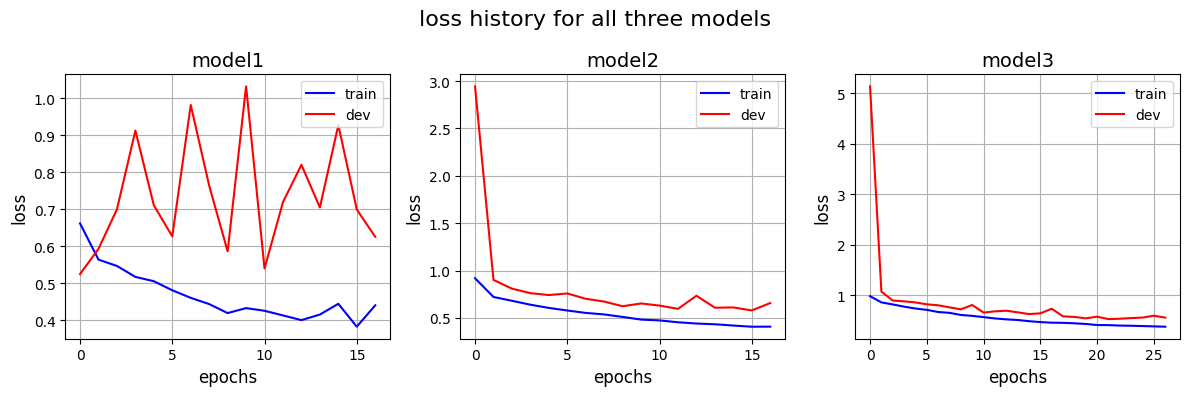

In [22]:
plot_history("loss")

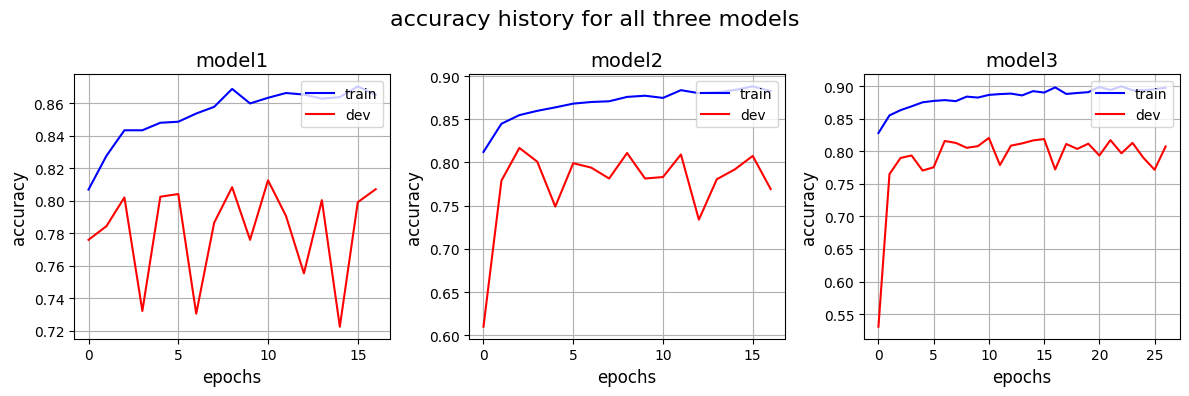

In [23]:
plot_history("accuracy")

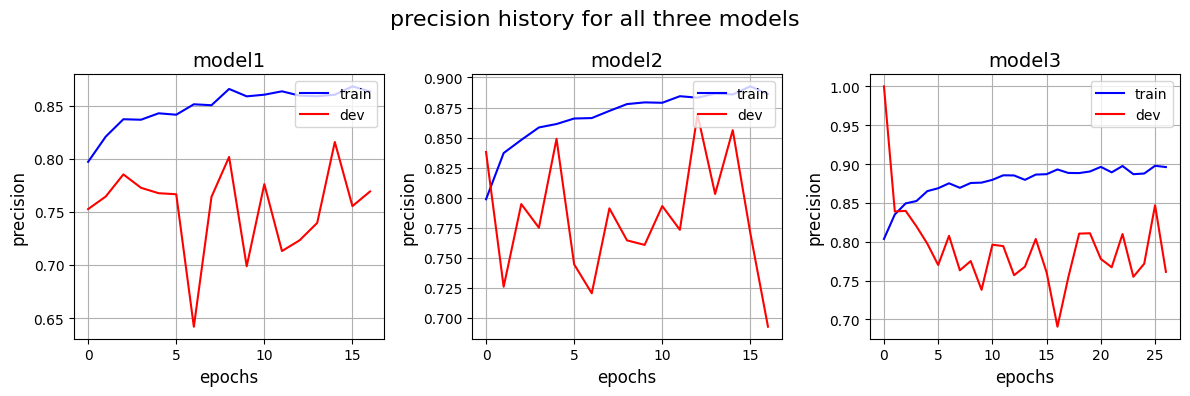

In [24]:
plot_history("precision")

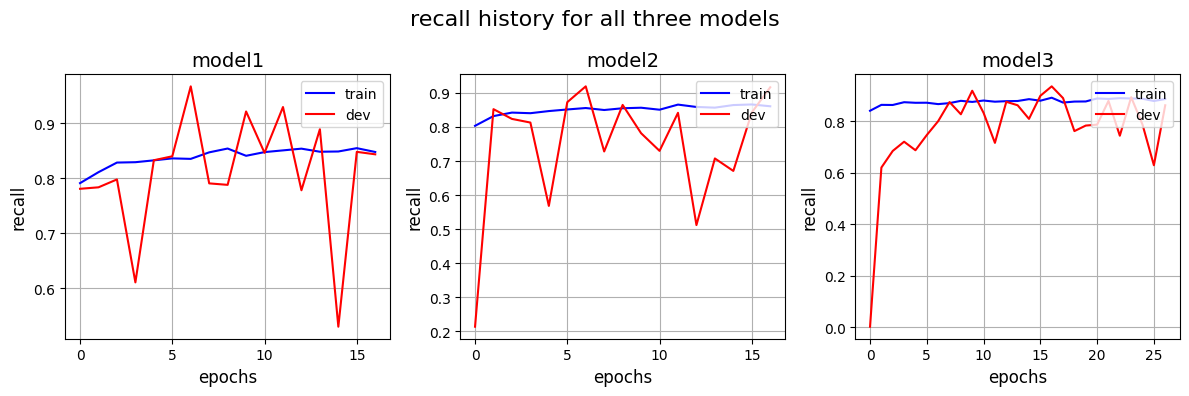

In [25]:
plot_history("recall")

Model 3 appears to be the most promising. Further tuning of hyperparameters is worth trying:
1. Decrease learning rate from 0.0001 to 0.00005 to smoothen out curves
2. see how the metrics look when thresholds are changed
3. Check F1 scores (trade-off between precision adn recall)
4. Calculate AUC

In [9]:
# 1. checking if decreasing learning rate from 0.0001 to 0.00005 helps
# it will take longer to converge of course

model3.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005),
                metrics = ["accuracy", Precision(name = "precision"), Recall(name = "recall")])

#print model summary
print("summary of model3\n")
model3.summary()

#introducing early stopping and model checkpoint
early_stop = EarlyStopping(monitor = "val_recall", patience = 15, restore_best_weights = True, mode = "max")
 
checkpoint = ModelCheckpoint(f"/kaggle/working/model3.keras", monitor = "val_recall", save_best_only = True)

#train the model
print(f"Training model3....")
history = model3.fit(
    train,
    validation_data = dev,
    epochs = 50,
    callbacks = [early_stop, checkpoint]
)
print("....Done!\n")






summary of model3



Model: "model3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,813,121 (25.99 MB)

 Trainable params: 6,812,161 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

Training model3....
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746728433.802069     111 service.cc:148] XLA service 0x7ef8b00044e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746728433.802901     111 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746728434.466142     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/297 ━━━━━━━━━━━━━━━━━━━━ 1:23:48 17s/step - accuracy: 0.5312 - loss: 2.1144 - precision: 0.4400 - recall: 0.9167

I0000 00:00:1746728440.225467     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


297/297 ━━━━━━━━━━━━━━━━━━━━ 216s 673ms/step - accuracy: 0.8025 - loss: 1.0747 - precision: 0.7878 - recall: 0.7844 - val_accuracy: 0.6851 - val_loss: 1.2873 - val_precision: 0.7141 - val_recall: 0.5519
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 109s 356ms/step - accuracy: 0.8577 - loss: 0.8878 - precision: 0.8536 - recall: 0.8439 - val_accuracy: 0.8000 - val_loss: 1.0554 - val_precision: 0.7578 - val_recall: 0.8453
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 105s 345ms/step - accuracy: 0.8714 - loss: 0.8409 - precision: 0.8631 - recall: 0.8614 - val_accuracy: 0.7979 - val_loss: 0.9727 - val_precision: 0.7927 - val_recall: 0.7728
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 105s 345ms/step - accuracy: 0.8713 - loss: 0.8235 - precision: 0.8669 - recall: 0.8604 - val_accuracy: 0.8055 - val_loss: 0.9612 - val_precision: 0.7733 - val_recall: 0.8301
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 105s 347ms/step - accuracy: 0.8730 - loss: 0.8002 - precision: 0.8611 - recall: 0.8654 - val_accuracy: 0.7975 - val

In [12]:
#plotting histories
#redefining function
def plot_history_model(metric):
  fig, ax = plt.subplots(1, figsize = (6,6))
  a = "val_"
  ax.plot(history.history[metric], c = "blue", label = "train")
  ax.plot(history.history[a+metric], c = "red", label = "dev")
  ax.set_xlabel("epochs", size = 12)
  ax.set_ylabel(metric, size = 12)
  ax.legend(loc = "upper right")
  ax.grid(True)
  ax.set_title("Visualizing "+ metric, size = 14)
  if metric == "loss":
      ax.set_ylim(0, 2)
  else:
      ax.set_ylim(0.50, 1.0)

 

(None, None, None, None)

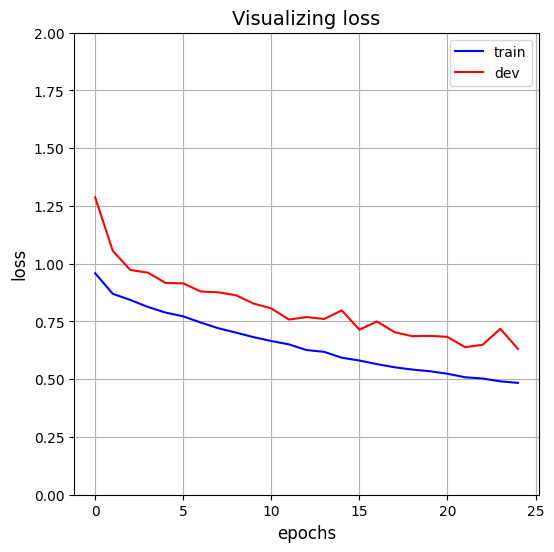

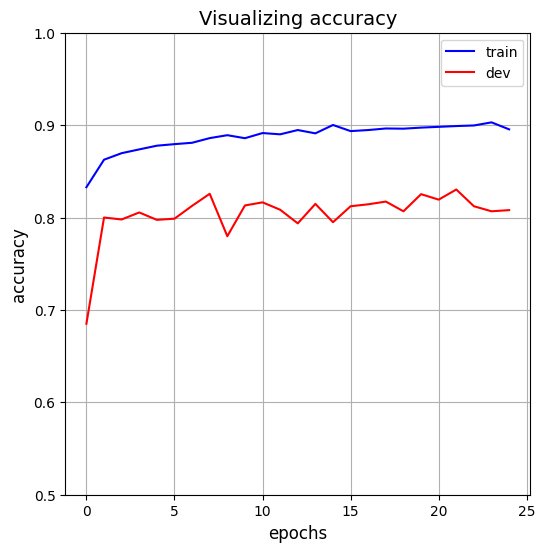

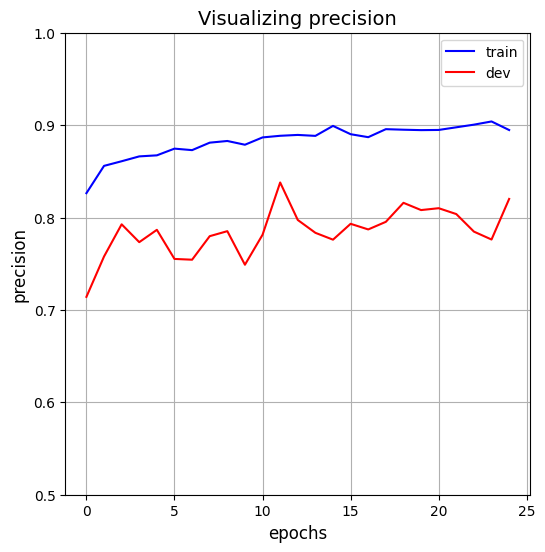

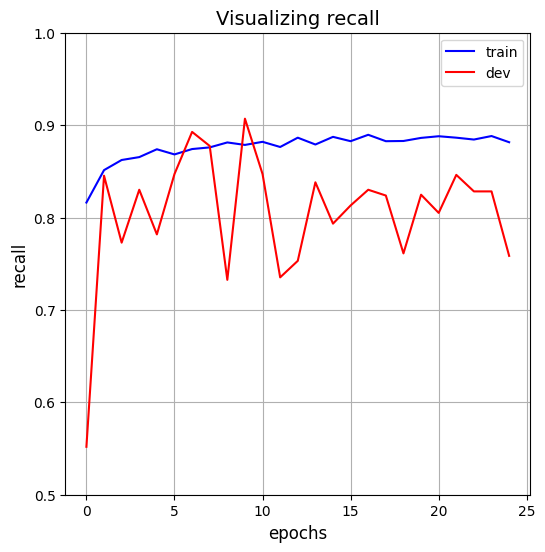

In [22]:
plot_history_model("loss"), plot_history_model("accuracy"), plot_history_model("precision"), plot_history_model("recall")

### Comparing performance metrics of the best weights under learning rate 0.0001 and 0.00005

| **Metric**           |**0.0001** | **0.00005** |
|----------------------|-----------:|------------:|
| **1. Accuracy**       | 0.8986     | 0.8878      |
| **2. Loss**           | 0.4597     | 0.6857      |
| **3. Val Accuracy**   | 0.7722     | 0.8131      |
| **4. Val Loss**       | 0.7365     | 0.8273      |
| **5. Precision**      | 0.8949     | 0.8794      |
| **6. Recall**         | 0.8933     | 0.8821      |
| **7. Val Precision**  | 0.6907     | 0.7489      |
| **8. Val Recall**     | 0.9347     | 0.9070      |

**Learning rate (alpha) = 0.0001 is more optimal.**

While it is a good practice to monitor val_recall while training the model, it is possible while using checkpoint, that you save the weights very early on when val_recall is very high (maybe out of chance) but other metrics are bad. For exmple, when loss is still very high but by chance, you get a high recall. To prevent saving models very early on in the training when metrics like loss are still very high, it is worth it to write a custom_checkpoint class to monitor both val_recall and val_loss so that models or weights are stored only when meeting a criteria (for eg. val_recall > 0.85 and val_loss < 0.4).

Additionally, I am writing a a custom early_stopping to monitor the convergence of both val_recall and val_loss and stop if both these values don't show an improvement (or reduction) by a certain value 

In [7]:
# Training model 3 again with learning rate = 0.0001 
#regulairzation parameter lambda = 0.001
#learning rate alpha = 0.0001

#monitoring val_recall for early stopping with patience = 15 but storing weights only when certain criteria are met

#defining CNN architecture

model3 = Sequential([
    #first convolutional layer
    Conv2D(32, (3,3), activation = "relu",padding = "same", kernel_regularizer = regularizers.l2(0.001), input_shape = (224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    #second convolutional layer
    Conv2D(64, (3,3), activation = "relu", padding = "same", kernel_regularizer = regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    #third convolutional layer
    Conv2D(128, (3,3), activation ="relu", padding = "same", kernel_regularizer = regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    #fourth convolutional layer
    Conv2D(256, (3,3), activation = "relu", padding = "same", kernel_regularizer = regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    #flatten
    Flatten(),

    #first dense layer
    Dense(units = 128, activation = "relu", kernel_regularizer = regularizers.l2(0.001)),
    Dropout(0.5),

    #last Dense layer
    Dense(units = 1, activation = "sigmoid"),

], name = "model3")

#compile

model3.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ["accuracy", Precision(name = "precision"), Recall(name = "recall")])

#print model summary
print("summary of model3\n")
model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747413238.287266      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


summary of model3



Model: "model3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,813,121 (25.99 MB)

 Trainable params: 6,812,161 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:
#defining my custom checkpoint class

class custom_checkpoint(Callback):
    def __init__(self, base_path, min_recall = 0.85, max_loss = 0.4): #these are default values
        super(custom_checkpoint, self).__init__() #ensures that the __init__ method of callback is executed
        self.base_path = base_path
        self.min_recall = min_recall
        self.max_loss = max_loss

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        val_recall = logs.get("val_recall")
        val_loss = logs.get("val_loss")

        if val_recall is not None and val_loss is not None:
            if val_recall > self.min_recall and val_loss < self.max_loss:
                filename = f"{self.base_path}_epoch{epoch+1:02d}_recall{val_recall:.4f}_loss{val_loss:.4f}.keras"
                print(f"\n Saving model at epoch {epoch+1} (val_recall={val_recall:.4f}, val_loss={val_loss:.4f}) to {filename}") #in keras, epochs are indexed from 0 (not 1)
                self.model.save(filename)

######################################

#defining my custom easrly_stopping class

class custom_early_stopping(Callback):
    def __init__(self, min_delta_recall=0.01, min_delta_loss=0.01, patience=10, restore_best_weights=True): #default values
        super(custom_early_stopping, self).__init__()
        self.min_delta_recall = min_delta_recall
        self.min_delta_loss = min_delta_loss
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.wait = 0
        self.stopped_epoch = 0
        self.best_val_recall = -np.Inf   
        self.best_val_loss = np.Inf    #setting initial best_val_loss to it to positive infinity
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_val_recall = logs.get("val_recall")
        current_val_loss = logs.get("val_loss")

        if current_val_recall is None or current_val_loss is None:
            print("val_recall or val_loss not available. Skipping CustomEarlyStopping check.")
            return

        recall_improved = (current_val_recall - self.best_val_recall) > self.min_delta_recall
        loss_improved = (self.best_val_loss - current_val_loss) > self.min_delta_loss

        if recall_improved or loss_improved:
            if recall_improved:
                self.best_val_recall = current_val_recall
            if loss_improved:
                self.best_val_loss = current_val_loss

            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                self.model.stop_training = True
                if self.restore_best_weights and self.best_weights is not None:
                    print(f"\n Restoring best weights from epoch with val_recall={self.best_val_recall:.4f}, val_loss={self.best_val_loss:.4f}")
                    self.model.set_weights(self.best_weights)
                print(f"\n Training stopped early at epoch {self.stopped_epoch} (no meaningful improvement in val_recall or val_loss)")

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"\n CustomEarlyStopping triggered at epoch {self.stopped_epoch}")
            
 ##########################################################################################       

early_stop = custom_early_stopping(min_delta_recall = 0.01, min_delta_loss = 0.01, patience = 15, restore_best_weights = True)
 
checkpoint = custom_checkpoint(base_path = "/kaggle/working/model3_pass", min_recall = 0.85, max_loss = 0.5)  #with min_val_recall = 0.85 and max_val_loss = 0.5

#train the model
print(f"Training model3....")
history = model3.fit(
    train,
    validation_data = dev,
    epochs = 50,
    callbacks = [early_stop, checkpoint]
)
print("....Done!\n")

Training model3....
Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 121s 398ms/step - accuracy: 0.8661 - loss: 0.8448 - precision: 0.8504 - recall: 0.8658 - val_accuracy: 0.8202 - val_loss: 0.9970 - val_precision: 0.7723 - val_recall: 0.8766
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 114s 374ms/step - accuracy: 0.8792 - loss: 0.7891 - precision: 0.8672 - recall: 0.8779 - val_accuracy: 0.8160 - val_loss: 0.9475 - val_precision: 0.7666 - val_recall: 0.8757
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 113s 371ms/step - accuracy: 0.8788 - loss: 0.7527 - precision: 0.8669 - recall: 0.8732 - val_accuracy: 0.8063 - val_loss: 0.8886 - val_precision: 0.7701 - val_recall: 0.8390
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 115s 377ms/step - accuracy: 0.8838 - loss: 0.7230 - precision: 0.8721 - recall: 0.8814 - val_accuracy: 0.7823 - val_loss: 0.8463 - val_precision: 0.7457 - val_recall: 0.8157
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 113s 372ms/step - accuracy: 0.8843 - loss: 0.6946 - precision: 0.8757 - recall: 0.88

(None, None, None, None)

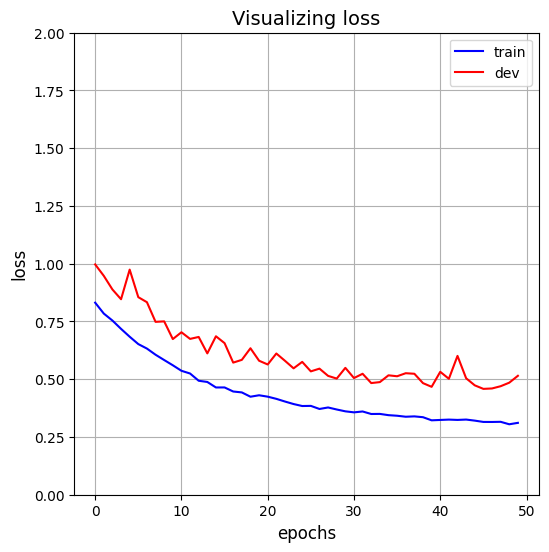

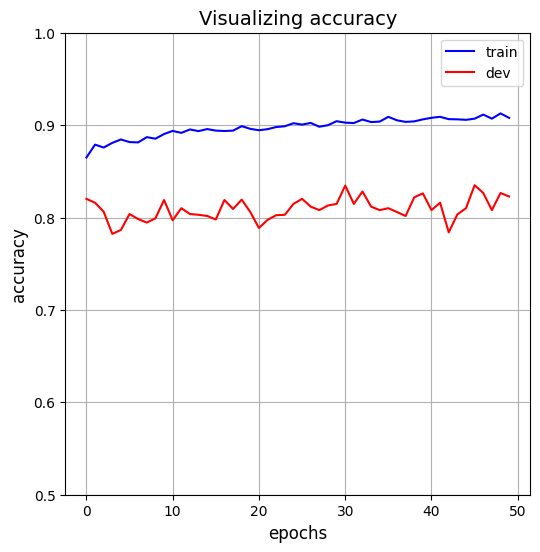

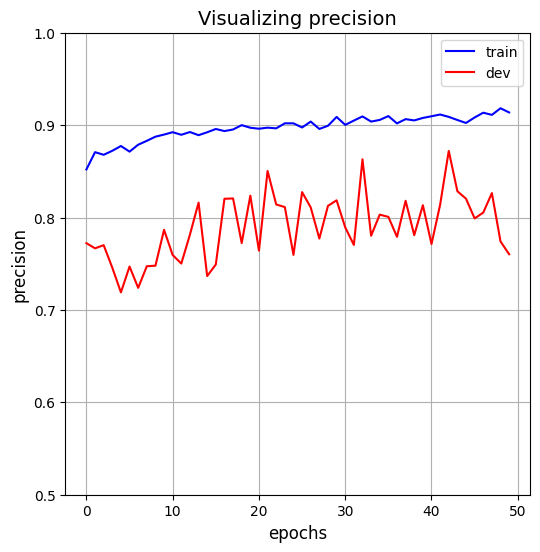

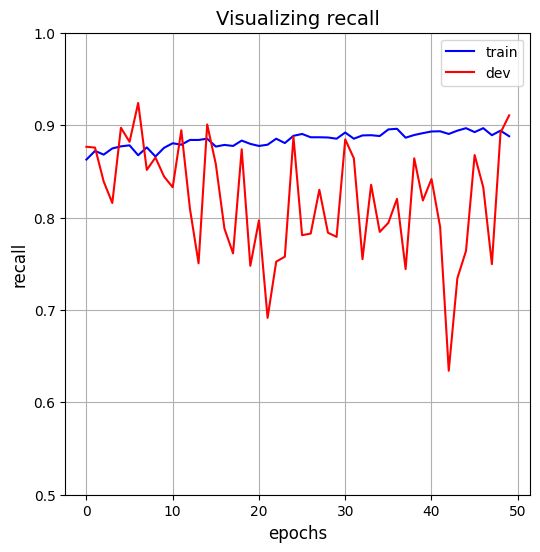

In [13]:
plot_history_model("loss"), plot_history_model("accuracy"), plot_history_model("precision"), plot_history_model("recall")


**Checkpoint saved the two models that matched the following criteria: val_recall > 0.85 and val_loss < 0.5. We can now see how these models perform acorss different thresholds (with the default being 0.5)**


In [46]:
# Adjust the path to match your actual model name

model_first = load_model("/kaggle/working/model3_pass_epoch39_recall0.8640_loss0.4831.keras")
model_second = load_model("/kaggle/working/model3_pass_epoch46_recall0.8676_loss0.4582.keras")

**Evaluating metrics for model_first:**

In [76]:
y_probs = []
y_true = []

for images, labels in dev:
    preds = model_first.predict(images)
    y_probs.extend(preds)
    y_true.extend(labels)
    
    if len(y_true) >= dev.samples:
        break

y_probs = np.array(y_probs).flatten()  # Flatten if shape is (N, 1)
y_true = np.array(y_true).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

(array([858.,  94.,  51.,  63.,  71., 110., 133., 153., 184., 658.]),
 array([6.47139677e-05, 1.00058243e-01, 2.00051770e-01, 3.00045311e-01,
        4.00038838e-01, 5.00032365e-01, 6.00025892e-01, 7.00019419e-01,
        8.00012946e-01, 9.00006473e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

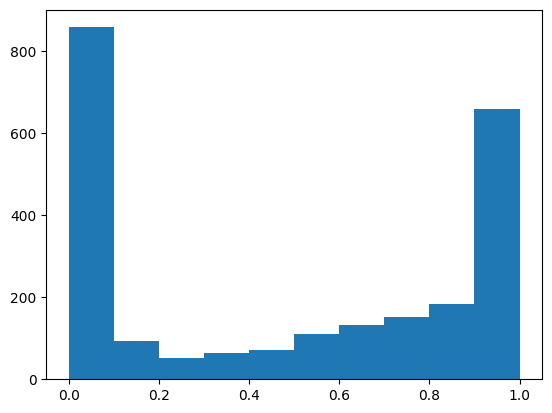

In [77]:
#taking a lot at the distribution of predicted probilities for model_first
plt.hist(y_probs)

In [78]:
#check how performance metrics of model_first vary acros different thresholds (on dev data)

threshold = [0.3, 0.4, 0.5, 0.6, 0.7]
accuracies = []
precisions = []
recalls = []
F1s = []
auc = roc_auc_score(y_true, y_probs)

for t in threshold:
    y_pred = (y_probs >= t).astype(int)
    accuracies.append(accuracy_score(y_true, y_pred))
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    F1s.append(f1_score(y_true, y_pred))


([<matplotlib.axis.XTick at 0x7d59947e6e50>,
 [Text(0.3, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6, 0, '0.6'),
  Text(0.7, 0, '0.7')])

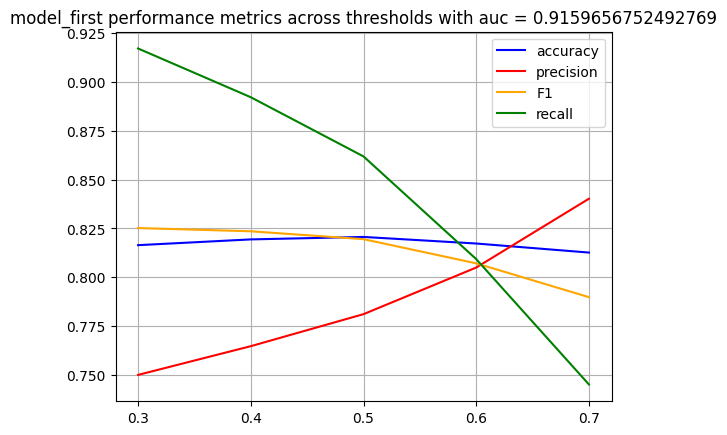

In [79]:
plt.plot(threshold, accuracies, c = "blue", label = "accuracy")
plt.plot(threshold, precisions, c = "red", label = "precision")
plt.plot(threshold, F1s, c = "orange", label = "F1")
plt.plot(threshold, recalls, c = "green", label = "recall")
plt.legend()
plt.title(f"model_first performance metrics across thresholds with auc = {auc}")
plt.grid()
plt.xticks(ticks = threshold, label = threshold)

**Evaluating metrics for model_second:**

In [82]:
y_probs = []
y_true= []

for images, labels in dev:
    preds = model_second.predict(images)
    y_probs.extend(preds)
    y_true.extend(labels)
    
    if len(y_true) >= dev.samples:
        break

y_probs = np.array(y_probs).flatten()  # Flatten if shape is (N, 1)
y_true = np.array(y_true).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

(array([851.,  97.,  57.,  70.,  78., 113., 130., 150., 165., 664.]),
 array([1.46733903e-04, 1.00132063e-01, 2.00117394e-01, 3.00102711e-01,
        4.00088042e-01, 5.00073373e-01, 6.00058675e-01, 7.00044036e-01,
        8.00029337e-01, 9.00014699e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

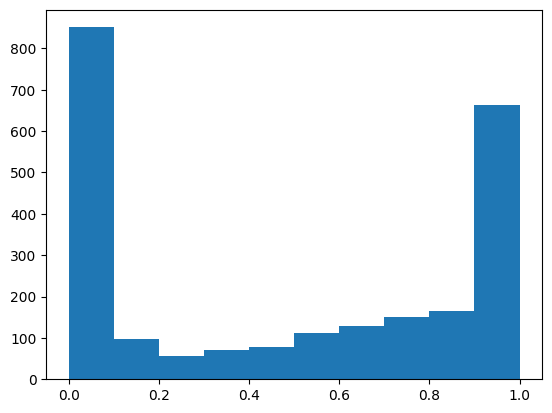

In [83]:
#taking a lot at the distribution of predicted probilities for model_second
plt.hist(y_probs)

In [84]:
#check how performance metrics of model_second vary across different thresholds (on dev data)

threshold = [0.3, 0.4, 0.5, 0.6, 0.7]
accuracies = []
precisions = []
recalls = []
F1s = []
auc = roc_auc_score(y_true, y_probs)

for t in threshold:
    y_pred = (y_probs >= t).astype(int)
    accuracies.append(accuracy_score(y_true, y_pred))
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    F1s.append(f1_score(y_true, y_pred))


([<matplotlib.axis.XTick at 0x7d58e0258cd0>,
 [Text(0.3, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6, 0, '0.6'),
  Text(0.7, 0, '0.7')])

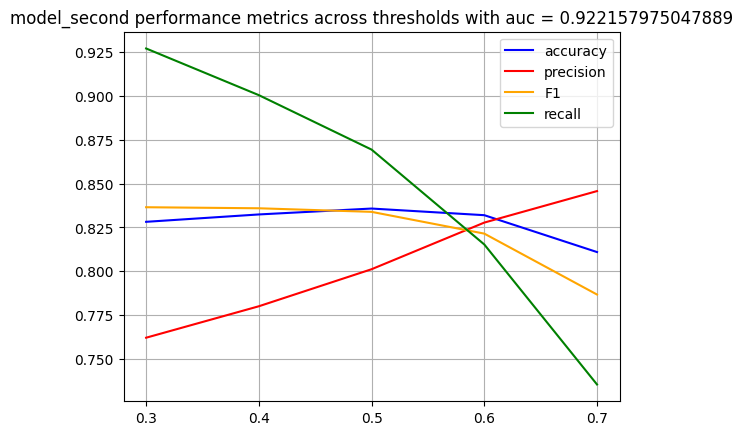

In [85]:
plt.plot(threshold, accuracies, c = "blue", label = "accuracy")
plt.plot(threshold, precisions, c = "red", label = "precision")
plt.plot(threshold, F1s, c = "orange", label = "F1")
plt.plot(threshold, recalls, c = "green", label = "recall")
plt.legend()
plt.title(f"model_second performance metrics across thresholds with auc = {auc}")
plt.grid()
plt.xticks(ticks = threshold, label = threshold)


**Comparing the performance metrics of model_first and model_second on the dev data across thresholds**

| Threshold | Model        | Accuracy | Precision | Recall  | F1-score |
|-----------|--------------|----------|-----------|---------|----------|
| **0.3**   | model_first  | 0.8164   | 0.7500    | 0.9171  | 0.8252   |
|           | model_second | 0.8282   | 0.7620    | 0.9272  | 0.8365   |
| **0.4**   | model_first  | 0.8194   | 0.7647    | 0.8922  | 0.8235   |
|           | model_second | 0.8324   | 0.7800    | 0.9005  | 0.8359   |
| **0.5**   | model_first  | 0.8206   | 0.7811    | 0.8619  | 0.8195   |
|           | model_second | 0.8358   | 0.8011    | 0.8694  | 0.8339   |
| **0.6**   | model_first  | 0.8173   | 0.8050    | 0.8093  | 0.8071   |
|           | model_second | 0.8320   | 0.8278    | 0.8153  | 0.8215   |
| **0.7**   | model_first  | 0.8126   | 0.8402    | 0.7451  | 0.7898   |
|           | model_second | 0.8109   | 0.8458    | 0.7353  | 0.7867   |

Comparing the metrics and taking into consideration the importance of recall for medical diagnostics, model_second at 0.4 threshold performs the best

In [21]:
#loading model_second to test its performance on the test dataset (new dataset that the model has not seen yet)

model_melanoma = load_model("/kaggle/input/melanoma-model/model3_pass_epoch46_recall0.8676_loss0.4582.keras")

I0000 00:00:1747925801.343176      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [22]:
#testing the model on my test data

y_probs = []
y_true = []

for images, labels in test:
    preds = model_melanoma.predict(images)
    y_probs.extend(preds)
    y_true.extend(labels)
    
    if len(y_true) >= test.samples:
        break

y_probs = np.array(y_probs).flatten()  # Flatten if shape is (N, 1)
y_true = np.array(y_true).astype(int)

I0000 00:00:1747925956.940716     133 service.cc:148] XLA service 0x7ff568506380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747925956.941450     133 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747925957.053154     133 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1747925958.865795     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

(array([747.,  98.,  61.,  53.,  61.,  79., 122., 161., 164., 454.]),
 array([1.17996926e-04, 1.00106195e-01, 2.00094402e-01, 3.00082594e-01,
        4.00070786e-01, 5.00059009e-01, 6.00047171e-01, 7.00035393e-01,
        8.00023615e-01, 9.00011778e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

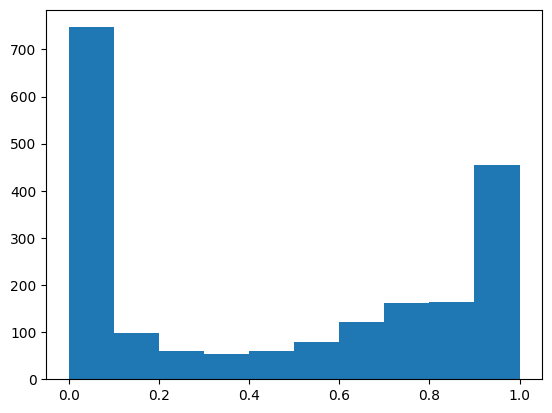

In [23]:
#taking a look at the range of preicted probabilites for the melanoma_model
plt.hist(y_probs)

In [25]:
#predicting with threshold = 0.4
auc = roc_auc_score(y_true, y_probs)


y_pred = (y_probs >= 0.4).astype(int)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
F1 = f1_score(y_true, y_pred)

In [27]:
auc, accuracy, precision, recall, F1

(0.975639, 0.9275, 0.9106628242074928, 0.948, 0.9289563939245468)

| Metric    | Value   |
|-----------|---------|
| AUC       | 0.9756  |
| Accuracy  | 0.9275  |
| Precision | 0.9107  |
| Recall    | 0.9480  |
| F1 Score  | 0.9290  |

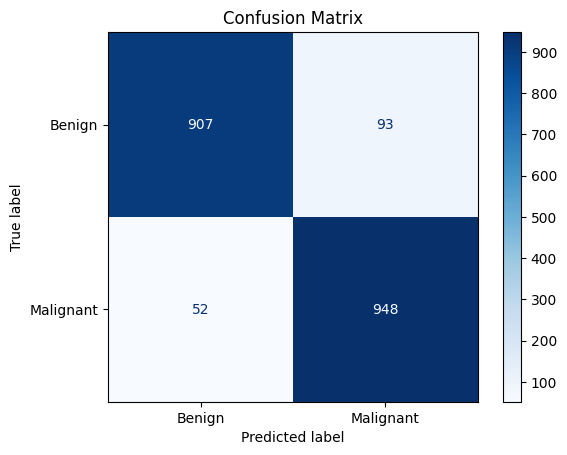

In [31]:
#plotting a confusion matrix to get an idea of true negatives, true positives, false negatives, and false positives

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Benign", "Malignant"])
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

The **melanoma_model** seems to be performing very well with a recall of **94.8%**.  
From the confusion matrix, it is also clear that the number of false positives and false negatives are relatively low.  
Overall, great performance!


### Download and use the melanoma diagnosis model 

You can access the pretrained `melanoma_model.keras` file here:  
[Melanoma Model on Kaggle](https://www.kaggle.com/datasets/nadidixit/melanoma-model)
 
Use the following code to load the model after adding it to your notebook:
```
from tensorflow import keras
model = keras.models.load_model('/kaggle/input/melanoma-model/melanoma_model.keras')
```